# Sequential Tempering for Bayesian Inference and Reliability analyses

The general framework: one wants to sample from a distribution of the form

\begin{equation}
    p_1 \left( x \right) = \frac{q_1 \left( x \right)p_0 \left( x \right)}{Z_1}
\end{equation}

where $ q_1 \left( x \right) $ and $ p_0 \left( x \right) $ can be evaluated; and potentially estimate the constant $ Z_1 = \int q_1 \left( x \right)p_0 \left( x \right) dx $.

Sequential tempering introduces a sequence of intermediate distributions:

\begin{equation}
    p_{\beta_j} \left( x \right) \propto q \left( x, \beta_j \right)p_0 \left( x \right)
\end{equation}

for values of $ \beta_j $ in $ [0, 1] $. The algorithm starts with $ \beta_0 = 0 $, which samples from the reference distribution $ p_0 $, and ends for some $ j = m $ such that $ \beta_m = 1 $, sampling from the target. First, a set of sample points is generated from $ p_0 = p_{\beta_0} $, and then these are resampled according to some weights $ w_0 $ such that after resampling the points follow $ p_{\beta_1} $. This procedure of resampling is carried out at each intermediate level $ j $ - resampling the points distributed as $ p_{\beta_{j}} $ according to weights $ w_{j} $ such that after resampling, the points are distributed according to $ p_{\beta_{j+1}} $. As the points are sequentially resampled to follow each intermediate distribution, eventually they are resampled from $ p_{\beta_{m-1}} $ to follow $ p_{\beta_{m}} = p_1 $.

The weights are calculated as

\begin{equation}
    w_j = \frac{q \left( x, \beta_{j+1} \right)}{q \left( x, \beta_j \right)}
\end{equation}

The normalizing constant is calculated during the generation of samples, as

\begin{equation}
    Z_1 = \prod_{j = 0}^{m-1} \left\{ \frac{\sum_{i = 1}^{N_j} w_j}{N_j} \right\}
\end{equation}

where $ N_j $ is the number of sample points generated from the intermediate distribution $ p_{\beta_j} $.

## Bayesian Inference

In the Bayesian setting, $ p_0 $ is the prior, and $ q \left( x, \beta_j \right) = \mathcal{L}\left( data, x \right) ^{\beta_j} $

In [1]:
from UQpy.RunModel import RunModel
import numpy as np
from UQpy.Distributions import Uniform, Normal, JointInd, MVNormal
from UQpy.SampleMethods.TemperingMCMC import SequentialTemperingMCMC
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm, uniform
from UQpy.SampleMethods.MCMC import *

In [2]:
def likelihood(x, b):
    mu1 = np.array([1., 1.])
    mu2 = -0.8 * np.ones(2)
    w1 = 0.5
    # Width of 0.1 in each dimension
    sigma1 = np.diag([0.02, 0.05])
    sigma2 = np.diag([0.05, 0.02])

    # Posterior is a mixture of two gaussians
    like = np.exp(np.logaddexp(np.log(w1) + multivariate_normal.logpdf(x=x, mean=mu1, cov=sigma1),
                               np.log(1.-w1) + multivariate_normal.logpdf(x=x, mean=mu2, cov=sigma2)))
    return like**b


prior = JointInd(marginals=[Uniform(loc=-2.0, scale=4.0), Uniform(loc=-2.0, scale=4.0)])

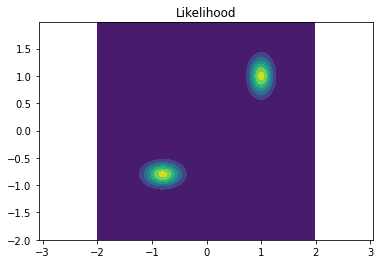

Evidence computed analytically = 0.062499877742670795


In [3]:
# estimate evidence
def estimate_evidence_from_prior_samples(size):
    samples = -2. + 4 * np.random.uniform(size=size * 2).reshape((size, 2))
    return np.mean(likelihood(samples, 1.0))

def func_integration(x1, x2):
    x = np.array([x1, x2]).reshape((1, 2))
    return likelihood(x, 1.0) * (1. / 4) ** 2

def estimate_evidence_from_quadrature():
    from scipy.integrate import dblquad
    ev = dblquad(func=func_integration, a=-2, b=2, gfun=lambda x: -2, hfun=lambda x: 2)
    return ev

x = np.arange(-2, 2, 0.02)
y = np.arange(-2, 2, 0.02)
xx, yy = np.meshgrid(x, y)
z = likelihood(np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=-1), 1.0)
h = plt.contourf(x,y,z.reshape(xx.shape))
plt.title('Likelihood')
plt.axis('equal')
plt.show()

#for nMC in [50000, 100000, 500000, 1000000]:
#    print('Evidence = {}'.format(estimate_evidence_from_prior_samples(nMC)))
print('Evidence computed analytically = {}'.format(estimate_evidence_from_quadrature()[0]))


In [4]:
test = SequentialTemperingMCMC(dimension=2, nsamples=4000, pdf_intermediate=likelihood,
                               distribution_reference=prior, nchains=20, save_intermediate_samples=True,
                               percentage_resampling=10, mcmc_class=MH, verbose=True)

TMCMC Start
beta selected
Begin Resampling
Begin MCMC
Tempering level ended
beta selected
Begin Resampling
Begin MCMC
Tempering level ended
beta selected
Begin Resampling
Begin MCMC
Tempering level ended


Normalizing Constant = [0.06176359]
Tempering Parameters = [0.         0.078125   0.30859375 1.        ]


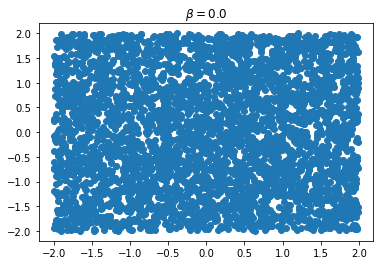

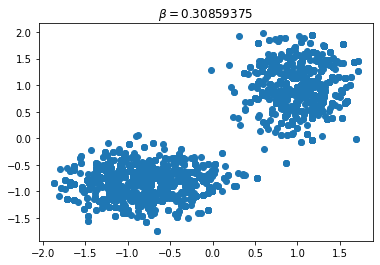

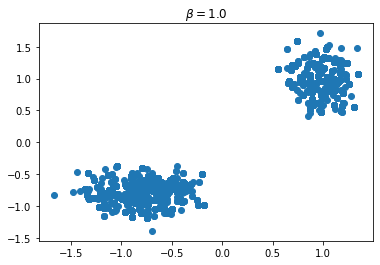

In [5]:
print('Normalizing Constant = ' + str(test.evidence))
print('Tempering Parameters = ' + str(test.temper_param_list))

plt.figure()
plt.scatter(test.intermediate_samples[0][:, 0], test.intermediate_samples[0][:, 1])
plt.title(r'$\beta = $' + str(test.temper_param_list[0]))
plt.show()

plt.figure()
plt.scatter(test.intermediate_samples[2][:, 0], test.intermediate_samples[2][:, 1])
plt.title(r'$\beta = $' + str(test.temper_param_list[2]))
plt.show()

plt.figure()
plt.scatter(test.samples[:, 0], test.samples[:, 1])
plt.title(r'$\beta = $' + str(test.temper_param_list[-1]))
plt.show()

# Reliability

In the reliability context, $ p_0 $ is the pdf of the parameters, and

\begin{equation}
    q \left( x, \beta_j \right) = I_{\beta_j} \left( x \right) = \frac{1}{1 + \exp{\left( \frac{G \left( x \right)}{\frac{1}{\beta_j} - 1} \right)}}
\end{equation}

where $ G \left( x \right) $ is the performance function, negative if the system fails, and $ I_{\beta_j} \left( x \right) $ are smoothed versions of the indicator function.

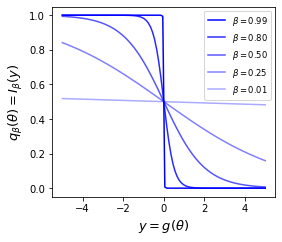

In [6]:
from scipy.stats import norm
def indic_sigmoid(y, beta):
    return 1. / (1. + np.exp(y / (1./beta-1.)))

fig, ax = plt.subplots(figsize=(4, 3.5))
ys = np.linspace(-5, 5, 100)
for i, s in enumerate(1./np.array([1.01, 1.25, 2., 4., 70.])):
    ax.plot(ys, indic_sigmoid(y=ys, beta=s), label=r'$\beta={:.2f}$'.format(s), color='blue', alpha=1. - i/6)
ax.set_xlabel(r'$y=g(\theta)$', fontsize=13)
ax.set_ylabel(r'$q_{\beta}(\theta)=I_{\beta}(y)$', fontsize=13)
#ax.set_title(r'Smooth versions of the indicator function', fontsize=14)
ax.legend(fontsize=8.5)
plt.show()

In [7]:
beta = 2 # Specified Reliability Index
rho = 0.7 # Specified Correlation
dim = 2  # Dimension


# Define the correlation matrix
C = np.ones((dim, dim)) * rho
np.fill_diagonal(C, 1)
print(C)

# Print information related to the true probability of failure
e, v = np.linalg.eig(np.asarray(C))
beff = np.sqrt(np.max(e)) * beta
print(beff)
from scipy.stats import norm
pf_true = norm.cdf(-beta)
print('True pf={}'.format(pf_true))

[[1.  0.7]
 [0.7 1. ]]
2.6076809620810595
True pf=0.022750131948179195


Prob. failure (MC) = 0.0232


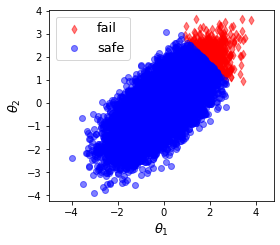

In [8]:
def estimate_Pf_0(samples, model_values):
    mask = model_values <= 0
    return np.sum(mask)/len(mask)


model = RunModel(model_script='reliability_funcs.py', model_object_name="correlated_gaussian", ntasks=1, 
                 b_eff=beff, d=dim)
#model = RunModel(model_script='TMCMC_test_reliability_fn.py', model_object_name="correlated_gaussian", ntasks=1, 
#                 b_eff=beff, d=dim)
samples = MVNormal(mean=np.zeros((2,)), cov=np.array([[1, 0.7], [0.7, 1]])).rvs(nsamples=20000)
model.run(samples=samples, append_samples=False)
model_values = np.array(model.qoi_list)

print('Prob. failure (MC) = {}'.format(estimate_Pf_0(samples, model_values)))

fig, ax = plt.subplots(figsize=(4, 3.5))
mask = model_values <= 0
ax.scatter(samples[mask, 0], samples[mask, 1], color='red', label='fail', alpha=0.5, marker='d')
ax.scatter(samples[~mask, 0], samples[~mask, 1], color='blue', label='safe', alpha=0.5)
plt.axis('equal')
#plt.title('Failure domain for reliability problem', fontsize=14)
plt.xlabel(r'$\theta_{1}$', fontsize=13)
plt.ylabel(r'$\theta_{2}$', fontsize=13)
ax.legend(fontsize=13)
fig.tight_layout()
plt.show()

In [9]:
def indic_sigmoid(y, b):
    return 1.0 / (1.0 + np.exp((y*b) / (1.0-b)))

def factor_param(x, b):
    model.run(samples=x, append_samples=False)
    G_values = np.array(model.qoi_list)
    return indic_sigmoid(G_values, b)


prior = MVNormal(mean=np.zeros((2,)), cov=C)

test = SequentialTemperingMCMC(dimension=2, nsamples=3000, pdf_intermediate=factor_param,
                               distribution_reference=prior, nchains=20, save_intermediate_samples=True,
                               percentage_resampling=10, mcmc_class=MH, verbose=True)

TMCMC Start
beta selected
Begin Resampling
Begin MCMC
Tempering level ended
beta selected
Begin Resampling
Begin MCMC
Tempering level ended
beta selected
Begin Resampling
Begin MCMC
Tempering level ended
beta selected
Begin Resampling
Begin MCMC
Tempering level ended


Estimated Probability of Failure = [0.02552598]
Tempering Parameters = [0.         0.375      0.58984375 0.84619141 1.        ]


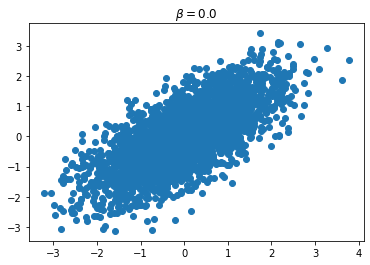

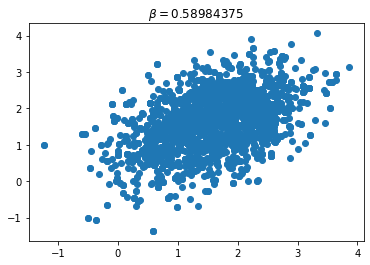

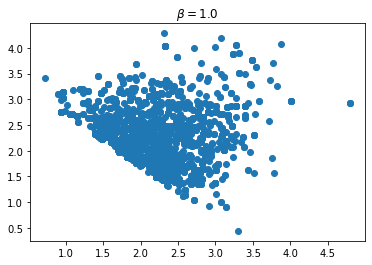

In [10]:
print('Estimated Probability of Failure = ' + str(test.evidence))
print('Tempering Parameters = ' + str(test.temper_param_list))

plt.figure()
plt.scatter(test.intermediate_samples[0][:, 0], test.intermediate_samples[0][:, 1])
plt.title(r'$\beta = $' + str(test.temper_param_list[0]))
plt.show()

plt.figure()
plt.scatter(test.intermediate_samples[2][:, 0], test.intermediate_samples[2][:, 1])
plt.title(r'$\beta = $' + str(test.temper_param_list[2]))
plt.show()

plt.figure()
plt.scatter(test.samples[:, 0], test.samples[:, 1])
plt.title(r'$\beta = $' + str(test.temper_param_list[-1]))
plt.show()